In [1]:
from math import sqrt

import numpy as np 
import pandas as pd
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
sns.set_style('darkgrid')
%matplotlib inline

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

from sklearn.metrics import mean_squared_error

import os
print(os.listdir("../input"))
files_list = os.listdir('../input')

['Chicago_Crimes_2008_to_2011.csv', 'Chicago_Crimes_2005_to_2007.csv', 'Chicago_Crimes_2012_to_2017.csv', 'Chicago_Crimes_2001_to_2004.csv']


In [2]:
# This is specific to Kaggle kernels
files_path = '../input/'

In [3]:
%%time
# All the imports take in consideration file location based on kaggle data structure
print('Reading:', files_list[3])
print('Discarding bad lines...')
c1 = pd.read_csv(files_path + files_list[3], error_bad_lines=False)
print('Reading:', files_list[1])
print('Discarding bad lines...')
c2 = pd.read_csv(files_path + files_list[1], error_bad_lines=False)
print('Reading:', files_list[0])
print('Discarding bad lines...')
c3 = pd.read_csv(files_path + files_list[0], error_bad_lines=False)
print('Reading:', files_list[2])
print('Discarding bad lines...')
c4 = pd.read_csv(files_path + files_list[2], error_bad_lines=False)

Reading: Chicago_Crimes_2001_to_2004.csv
Discarding bad lines...


b'Skipping line 1513591: expected 23 fields, saw 24\n'
<string>:2: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.


Reading: Chicago_Crimes_2005_to_2007.csv
Discarding bad lines...


b'Skipping line 533719: expected 23 fields, saw 24\n'


Reading: Chicago_Crimes_2008_to_2011.csv
Discarding bad lines...


b'Skipping line 1149094: expected 23 fields, saw 41\n'


Reading: Chicago_Crimes_2012_to_2017.csv
Discarding bad lines...
CPU times: user 41.8 s, sys: 3.56 s, total: 45.4 s
Wall time: 45.6 s


In [4]:
print('Joining files...')
all_data = pd.concat([c1, c2, c3, c4], ignore_index=True)
print('Done!')

Joining files...
Done!


In [5]:
all_data.drop(['Unnamed: 0', 'ID', 'Case Number', 'Block', 'IUCR', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location'],
             axis=1, inplace=True)

In [6]:
%%time
# For simplification purposes, I'll fill most missing values with their respective column modes and means
print('Preparing the data...')
all_data['Location Description'] = all_data['Location Description'].fillna(all_data['Location Description'].mode()[0])
all_data['District'] = all_data['District'].fillna(all_data['District'].mode()[0])
all_data['Ward'] = all_data['Ward'].fillna(all_data['Ward'].mean())
all_data['Community Area'] = all_data['Community Area'].fillna(all_data['Community Area'].mode()[0])
all_data['Count'] = 1
print('Done!')

Preparing the data...
Done!
CPU times: user 3.18 s, sys: 816 ms, total: 3.99 s
Wall time: 3.98 s


In [7]:
all_data['Date'] = all_data['Date'].apply(lambda x: x.split(' ')[0])

In [8]:
%%time
print('Parsing dates...')
all_data['Date'] = pd.to_datetime(all_data['Date'], format= '%m/%d/%Y')
print('Done!')

Parsing dates...
Done!
CPU times: user 20.8 s, sys: 564 ms, total: 21.4 s
Wall time: 21.2 s


In [9]:
df = all_data.loc[all_data['Primary Type'] == 'HOMICIDE']
df.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Updated On,Count
1438,2001-01-01,HOMICIDE,FIRST DEGREE MURDER,CHA STAIRWELL,False,False,1125,11.0,2.000000,28.0,2001.0,08/17/2015 03:03:40 PM,1
1445,2001-01-01,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,1414,14.0,35.000000,22.0,2001.0,08/17/2015 03:03:40 PM,1
1450,2001-01-04,HOMICIDE,FIRST DEGREE MURDER,BASEMENT,True,False,1021,10.0,22.620886,25.0,2001.0,08/17/2015 03:03:40 PM,1
1457,2001-01-06,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2535,25.0,22.620886,25.0,2001.0,08/17/2015 03:03:40 PM,1
1468,2001-01-05,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,611,6.0,22.620886,25.0,2001.0,08/17/2015 03:03:40 PM,1


In [10]:
all_data['Year'] = all_data['Year'].astype('int')

In [11]:
all_data.drop(1602847, axis=0, inplace=True)
drop_2017 = all_data.loc[all_data['Year'] == 2017]
all_data.drop(drop_2017.index, axis=0, inplace=True)

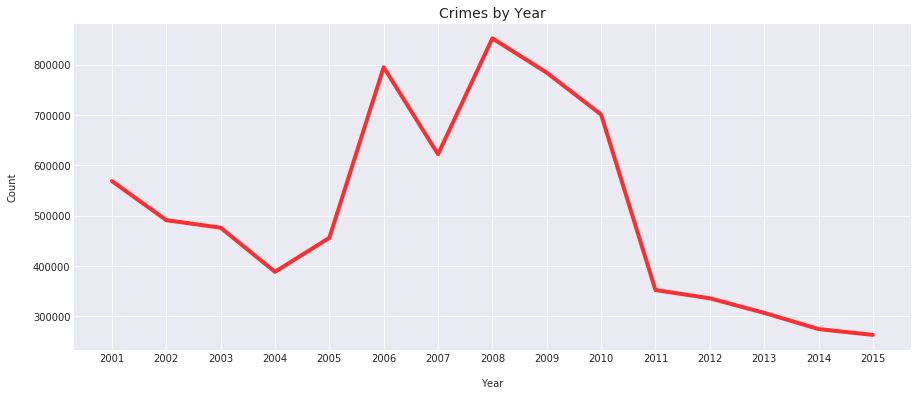

In [12]:
indexes = all_data.Year.value_counts().sort_index().index

plt.figure(figsize=(15, 6))
plt.title('Crimes by Year', fontsize=14)
plt.xlabel('\nYear')
plt.ylabel('Count\n')
plt.xticks(indexes)
all_data['Year'].value_counts().sort_index()[:-1].plot(color='r', alpha=.8, linewidth=4)

In [13]:
m = all_data.loc[all_data['Primary Type'] == 'HOMICIDE']
m.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Updated On,Count
1438,2001-01-01,HOMICIDE,FIRST DEGREE MURDER,CHA STAIRWELL,False,False,1125,11.0,2.000000,28.0,2001,08/17/2015 03:03:40 PM,1
1445,2001-01-01,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,1414,14.0,35.000000,22.0,2001,08/17/2015 03:03:40 PM,1
1450,2001-01-04,HOMICIDE,FIRST DEGREE MURDER,BASEMENT,True,False,1021,10.0,22.620886,25.0,2001,08/17/2015 03:03:40 PM,1
1457,2001-01-06,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2535,25.0,22.620886,25.0,2001,08/17/2015 03:03:40 PM,1
1468,2001-01-05,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,611,6.0,22.620886,25.0,2001,08/17/2015 03:03:40 PM,1


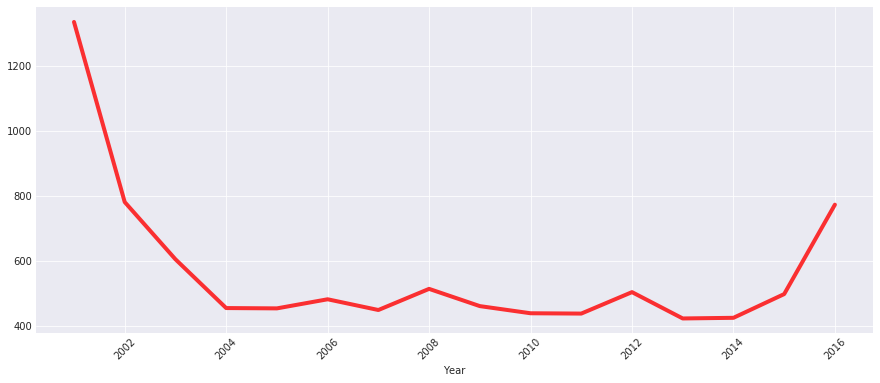

In [14]:
plt.figure(figsize=(15, 6))
m.groupby('Year')['Count'].count().plot(kind='line', color='r', alpha=.8, linewidth=4)
plt.xticks(rotation=45)
plt.show()

In [15]:
# Prophet requires you to name the columns 'ds' and 'y'
prophet_df = m.groupby('Date', as_index=False)['Count'].count()
prophet_df.columns = ['ds', 'y']
prophet_df.head()

,ds,y
0,2001-01-01,4
1,2001-01-04,4
2,2001-01-05,2
3,2001-01-06,8
4,2001-01-07,2


In [16]:
model = Prophet()
model.fit(prophet_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [17]:
future = model.make_future_dataframe(periods = 720, freq='D')
forecast = model.predict(future)

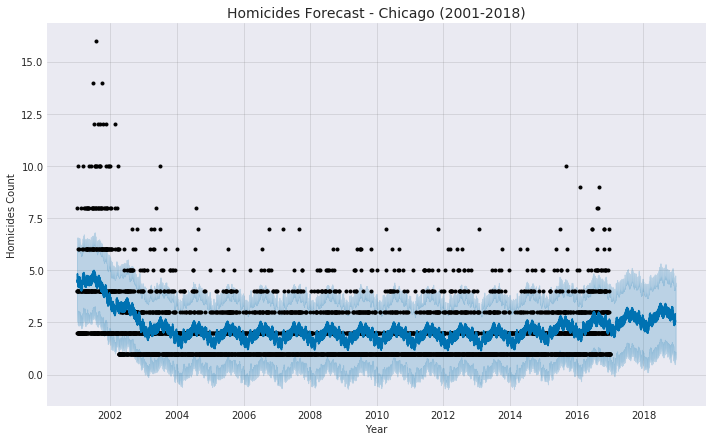

In [18]:
model.plot(forecast);
plt.title('Homicides Forecast - Chicago (2001-2018)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Homicides Count')
plt.show()

In [20]:
df_cv = cross_validation(model, horizon = '720 days')
df_cv.head()

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2007-02-23,1.142881,-0.783648,3.172548,1,2007-02-22
1,2007-02-24,1.787515,-0.232961,3.788330,1,2007-02-22
2,2007-02-25,1.584360,-0.779722,3.609147,2,2007-02-22
3,2007-02-26,1.203349,-0.917190,3.310084,1,2007-02-22
4,2007-02-27,1.290054,-0.779195,3.330203,2,2007-02-22


In [21]:
def rmse(prediction, true):
    return sqrt(mean_squared_error(true, prediction))

In [22]:
score = rmse(df_cv['y'], df_cv['yhat'])
print('Model\'s RMSE: {}'.format(round(score, 4)))

Model's RMSE: 1.1704
